In [1]:
%cat 0Source_Citation.txt

Source and citation

- This notebook is a part of the `pytheos` package.
- Website: http://github.com/SHDShim/pytheos.
- How to cite: S.-H. Shim (2017) Pytheos - a python tool set for equations of state. DOI: 10.5281/zenodo.802392


In [2]:
%matplotlib inline
# %matplotlib notebook # for interactive

For high dpi displays.

In [3]:
%config InlineBackend.figure_format = 'retina' 

# 0. General note

* This notebook shows an example of EOS fitting for static compression, focusing on applying a range of different pressure scales.  

* The result and data have been published in [Nisr et al. (2017, JGR)](http://onlinelibrary.wiley.com/doi/10.1002/2016JE005158/full).

# 1. Global setup

In [4]:
import numpy as np
from uncertainties import unumpy as unp
import pytheos as eos

# 2. Setup pressure scale and starting values

Setup dictionaries for pressure standard `(au_eos)` and equation to use `(fit_model)`.  This allows for eos fits with a wide range of different pressure scales.

In [5]:
au_eos = {'Fei2007': eos.gold.Fei2007bm3(), 'Dorogokupets2007': eos.gold.Dorogokupets2007(),
          'Yokoo2009': eos.gold.Yokoo2009()}
fit_model = {'Fei2007': eos.BM3Model(), 'Dorogokupets2007': eos.VinetModel(),
             'Yokoo2009': eos.BM3Model()}

SiC has two polymorphs, 3C and 6H, at the studied pressure range.  This notebook can conduct fitting for 3C.  However, changing the `sample` variable between `3C` and `6H` allows for reading different data files and apply different initial conditions for different phases.

In [6]:
sample = '3C' #'6H' #

Uncomment the following line to get some help.

In [7]:
#help(eos.gold.Yokoo2009)

We use the values from Zhuravlev (2013) for initial guess.

In [8]:
v0 = {'3C': 82.804, '6H': 124.27}
k0 = {'3C': 218., '6H': 218.}
k0p = {'3C': 3.75, '6H': 3.75}

# 3. Setup data

Read data file.  Data points are stored in `csv` files.  

In [9]:
data = np.recfromcsv('./data/'+sample+'-300EOS-final.csv', case_sensitive=True, deletechars='')

Sort the data in a reverse order based on the unit-cell volume of pressure standard.

In [10]:
n = data['V(Au)'].__len__()
ind = data['V(Au)'].argsort()[::-1][:n]

Make error propagation possible.

In [11]:
v_std = unp.uarray(data['V(Au)'][ind], data['sV(Au)'][ind])
v = unp.uarray(data['V('+sample+')'][ind], data['sV('+sample+')'][ind])

# 4. Fitting

The cell below runs an iteration to generate fitting for three different pressure scales.  We fix `v0` in this fitting example.

***Dorogokupets2007
[[Model]]
    Model(vinet_p)
[[Variables]]
    v0:    82.804 (fixed)
    k0:    243.007064 +/- 2.233012 (0.92%) (init= 218)
    k0p:   2.67891706 +/- 0.130837 (4.88%) (init= 3.75)
[[Correlations]] (unreported correlations are <  0.100)
    C(k0, k0p)                   = -0.944 

***Fei2007
[[Model]]
    Model(bm3_p)
[[Variables]]
    v0:    82.804 (fixed)
    k0:    241.179945 +/- 2.008704 (0.83%) (init= 218)
    k0p:   2.84051092 +/- 0.098156 (3.46%) (init= 3.75)
[[Correlations]] (unreported correlations are <  0.100)
    C(k0, k0p)                   = -0.933 

***Yokoo2009
[[Model]]
    Model(bm3_p)
[[Variables]]
    v0:    82.804 (fixed)
    k0:    241.985853 +/- 2.018187 (0.83%) (init= 218)
    k0p:   2.85352192 +/- 0.098392 (3.45%) (init= 3.75)
[[Correlations]] (unreported correlations are <  0.100)
    C(k0, k0p)                   = -0.933 



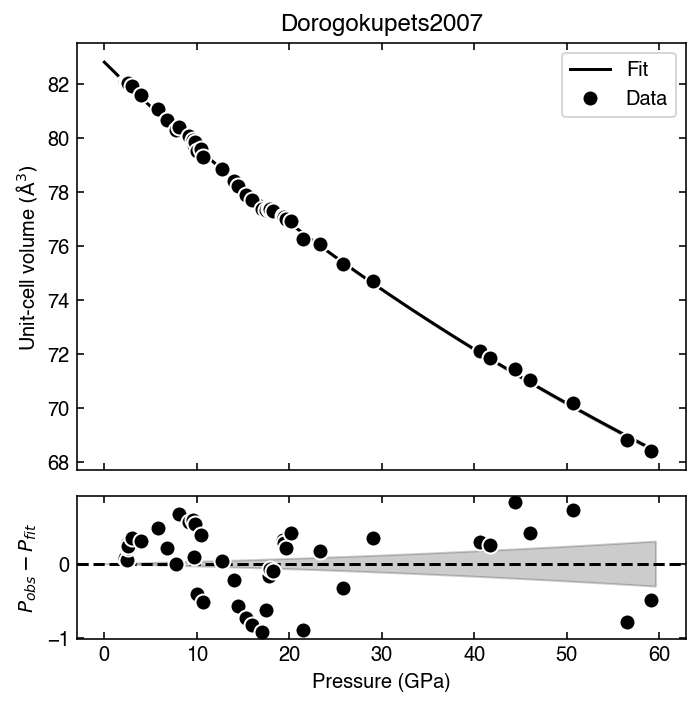

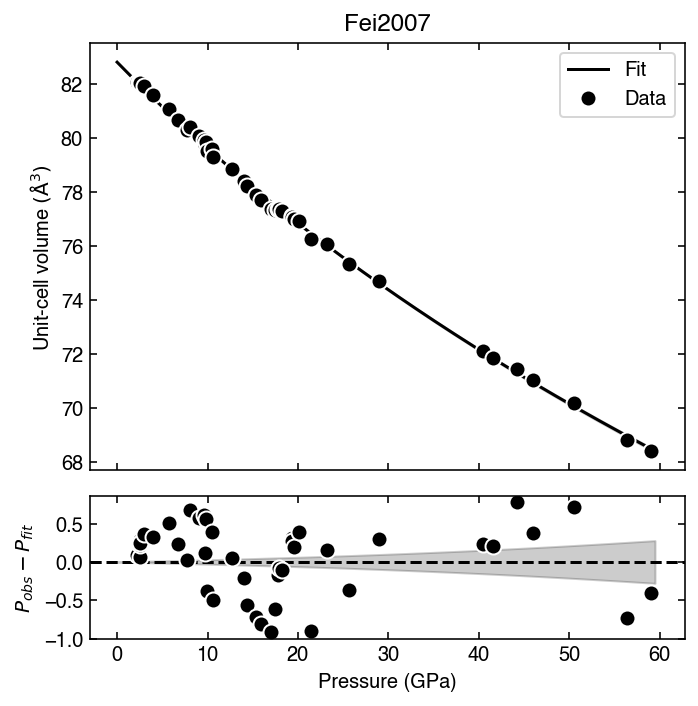

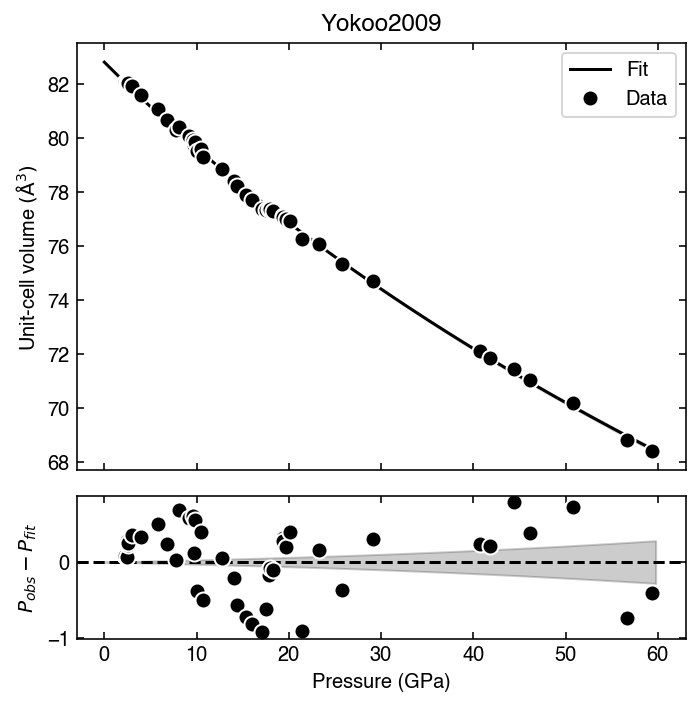

In [12]:
for key, value in au_eos.items():
    # set pressure standard to use
    p = au_eos[key].cal_pst(v_std)
    # set equation to fit
    model = fit_model[key]
    # assign initial values for the parameters
    params = model.make_params(v0=v0[sample], k0=k0[sample], k0p=k0p[sample])
    # fix v0
    params['v0'].vary = False
    # conduct fitting
    fitresult = model.fit(unp.nominal_values(p), params, v=unp.nominal_values(v))
    # generate text ouput for fitting result
    print('***'+key)
    print(fitresult.fit_report())
    # generate plots
    eos.plot.static_fit_result(fitresult, title=key)